In [23]:
import os
import sys
import numpy as np
import stingray
import scipy.io
from astropy.io import fits
import matplotlib.pyplot as plt
from nicer_fuc import *

# this ensures that all C output is redirected to the Jupyter output box
%load_ext wurlitzer

from xspec import *

In [2]:
print(os.environ.get('HEADAS'))

/home/pl/soft/heasoft/heasoft-6.31.1/x86_64-pc-linux-gnu-libc2.31


In [4]:
cwd = os.getcwd()
obs_list = get_obs(cwd)

In [5]:
for obs in obs_list:
    print_log(obs)
    obs = obs[0:10]

    lc_file = f'ni{obs}mpu7_sr1s.lc'
    lc_path = os.path.join(cwd,obs,lc_file)   

    with fits.open(lc_path) as data:

        #查看头文件信息
        header = data[1].header
        print(header)

        times = np.array(data[1].data['TIME'])
        rates = np.array(data[1].data['RATE'])

        src_name = data[1].header['object']
        print(src_name)

        ra,dec = get_ra_dec(src_name)
        print(ra,dec)

        timemjd = data[1].header['MJDREFI'] + data[1].header['MJDREFF'] + data[1].header['TSTART'] / 24 / 3600
        print(timemjd) #MJD时间

        t_zero = data[1].header['TIMEZERO']   #xspec能识别的时间戳
        print(t_zero)

        print()
        print(times[0])

        mjd_refi = data[1].header['MJDREFI']
        mjd_reff = data[1].header['MJDREFF']
        print(mjd_refi)

1050080126
XTENSION= 'BINTABLE'           / binary table extension                         BITPIX  =                    8 / 8-bit bytes                                    NAXIS   =                    2 / 2-dimensional binary table                     NAXIS1  =                   20 / width of table in bytes                        NAXIS2  =                 1739 / Number of bins                                 PCOUNT  =                    0 / size of special data area                      GCOUNT  =                    1 / one data group (required keyword)              TFIELDS =                    4 / number of fields in each row                   TTYPE1  = 'TIME    '           / label for field   1                            TFORM1  = 'D       '           / data format of field: 8-byte DOUBLE            TUNIT1  = 's       '           / physical unit of field                         TTYPE2  = 'RATE    '           / label for field   2                            TFORM2  = 'E       '         

In [6]:
from astropy.io import fits
import os

from astropy.io import fits
import os

def fits2dict(filename, par_list, ext):
    """
    从FITS文件的指定扩展中读取指定列或头文件键的数据并返回字典。

    参数:
    filename (str): FITS文件路径。
    par_list (list of str): 要提取的列名或头文件键名列表。
    ext (int): FITS文件的扩展号,默认将header全部添加。
        0 -> header, 如 'OBJECT', 'MJDREFI', 'MJDREFF', 'TIMEZERO' 等。
        1 -> EVENTS, 如 'TIME', 'RATE', 'ERROR' 等。
        2 -> FPM_SEL。
        3 -> GTI。
        4 -> PPS_TREND。

    返回:
    dict: 包含指定扩展数据的字典。
    """
    if type(filename) != str:
        raise TypeError("fits_file should be a string!")
    if type(ext) != int:
        raise TypeError("ext should be an integer!")
    if type(par_list) != list and type(par_list) != np.ndarray:
        raise TypeError("par_list should either be a list or an array!")

    with fits.open(filename) as hdul:
        results = {}

        header = hdul[0].header
        for key in par_list:
            if key.upper() in header:
                results[key] = header[key.upper()]

        data = hdul[ext].data
        if data is not None:
            for key in par_list:
                if key in data.names:
                    results[key] = data[key]
        else:
            raise ValueError(f"扩展 {ext} 不包含数据表。")

    return results

#光变示例
cwd = os.getcwd()
obs = '1050080126'
lc_file = f'ni{obs}mpu7_sr1s.lc'
lc_path = os.path.join(cwd, obs, lc_file)

par_list = ['TIME', 'RATE', 'ERROR', 'object', 'MJDREFI', 'MJDREFF', 'TIMEZERO']
#par_list = ['TIME','PI','PI_FAST','PI_RATIO']

data_dict = fits2dict(lc_path,par_list,1)
print(data_dict)

path_evt = '/home/pl/work/python-workspance/nicer-pl/1050080126/ni1050080126_0mpu7_cl.evt'
print(fits2dict(path_evt,['OBS_ID','START','STOP'],3))



{'object': '4U_1636-536', 'MJDREFI': 56658, 'MJDREFF': 0.000777592592592593, 'TIME': array([0.0000e+00, 1.0000e+00, 2.0000e+00, ..., 1.6925e+04, 1.6926e+04,
       1.6927e+04]), 'RATE': array([660., 650., 580., ..., 685., 658., 632.], dtype=float32), 'ERROR': array([25.690466, 25.495098, 24.083189, ..., 26.172504, 25.65151 ,
       25.13961 ], dtype=float32)}
{'OBS_ID': '1050080126', 'START': array([1.15028977e+08, 1.15029728e+08, 1.15030067e+08, 1.15045682e+08]), 'STOP': array([1.15029723e+08, 1.15030065e+08, 1.15030500e+08, 1.15045905e+08])}


In [7]:
att_var = ['TIME','MODE','SUBMODE_AZ','SUBMODE_EL']
mkf_var = ['TIME','ELV', 'BR_EARTH', 'SUNSHINE', 'FOV_FLAG', 'SUN_ANGLE',
           'MOON_ANGLE', 'ANG_DIST', 'SAA', 'SAA_TIME', 'COR_ASCA', 'COR_SAX',
           'MCILWAIN_L', 'NICER_SAA', 'TOT_ALL_COUNT', 'TOT_UNDER_COUNT',
           'TOT_OVER_COUNT', 'TOT_XRAY_COUNT']
hk_var = ['TIME','MPU_D_TEMP','MPU_A_TEMP','MPU_PWRBRDG_TEMP']


In [8]:
#att
att_path = '/home/pl/work/python-workspance/nicer-pl/ln/1050080128/auxil/ni1050080128.att.gz'
print(fits2dict(att_path,att_var,1))

{'TIME': array([1.18391359e+08, 1.18391359e+08, 1.18391359e+08, ...,
       1.18449173e+08, 1.18449173e+08, 1.18449173e+08]), 'MODE': array([1, 1, 1, ..., 1, 1, 1], dtype=uint8), 'SUBMODE_AZ': array([2, 2, 2, ..., 1, 1, 1], dtype=uint8), 'SUBMODE_EL': array([2, 2, 2, ..., 1, 1, 1], dtype=uint8)}


In [9]:
#cat
cat_path = '/home/pl/work/python-workspance/nicer-pl/ln/1050080128/auxil/ni1050080128.cat'
print(fits2dict(cat_path,['FILENAME','FORMAT'],1))


{'FILENAME': chararray(['xti/event_uf/ni1050080128_0mpu5_uf.evt',
           'xti/event_uf/ni1050080128_0mpu4_uf.evt',
           'xti/event_uf/ni1050080128_0mpu1_uf.evt',
           'xti/event_uf/ni1050080128_0mpu6_uf.evt',
           'xti/event_uf/ni1050080128_0mpu0_uf.evt',
           'xti/event_uf/ni1050080128_0mpu3_uf.evt',
           'xti/event_uf/ni1050080128_0mpu2_uf.evt',
           'xti/hk/ni1050080128_0mpu4.hk', 'xti/hk/ni1050080128_0mpu2.hk',
           'xti/hk/ni1050080128_0mpu5.hk', 'xti/hk/ni1050080128_0mpu0.hk',
           'xti/hk/ni1050080128_0mpu6.hk', 'xti/hk/ni1050080128_0mpu1.hk',
           'xti/hk/ni1050080128_0mpu3.hk',
           'xti/event_cl/ni1050080128_0mpu7_ufa.evt',
           'xti/event_cl/ni1050080128_0mpu7_cl.evt',
           'auxil/ni1050080128.orb', 'auxil/ni1050080128.cat',
           'auxil/ni1050080128.mkf', 'auxil/ni1050080128.att',
           'log/ni1050080128_joblog.html', 'log/ni1050080128_errlog.html'],
          dtype='<U64'), 'FORMAT': char

In [10]:
#mkf
mkf_path = '/home/pl/work/python-workspance/nicer-pl/ln/1050080128/auxil/ni1050080128.mkf'
print(fits2dict(mkf_path,['TIME','NICER_SAA','ANG_DIST'],1))

{'TIME': array([1.18391359e+08, 1.18391360e+08, 1.18391361e+08, ...,
       1.18449160e+08, 1.18449161e+08, 1.18449162e+08]), 'NICER_SAA': array([1, 1, 1, ..., 0, 0, 0], dtype=uint8), 'ANG_DIST': array([2.6391121e+01, 2.6389708e+01, 2.6123402e+01, ..., 6.9059203e-03,
       1.3806020e-03, 1.0438388e-02], dtype=float32)}


In [11]:
#orb
orb_path = '/home/pl/work/python-workspance/nicer-pl/ln/1050080128/auxil/ni1050080128.orb'
print(fits2dict(orb_path,['TIME','Vx','Vy'],1))


{'TIME': array([1.18391356e+08, 1.18391366e+08, 1.18391376e+08, ...,
       1.18449146e+08, 1.18449156e+08, 1.18449166e+08]), 'Vx': array([-6315.83973289, -6302.85145174, -6289.06145869, ...,
        5794.23187501,  5829.29467215,  5863.61012774]), 'Vy': array([-3752.69430032, -3810.05585701, -3866.93166503, ...,
        -250.74185907,  -180.8753436 ,  -110.98818823])}


In [12]:
#hk
print(fits2dict(path_evt,hk_var,1))


{'TIME': array([1.15028977e+08, 1.15028977e+08, 1.15028977e+08, ...,
       1.15045905e+08, 1.15045905e+08, 1.15045905e+08]), 'MPU_A_TEMP': array([34.53343915, 36.33558246, 35.91154874, ..., 37.28965833,
       34.95747287, 36.65360775])}


In [13]:
#uf_file = fits.open(cwd +'/ln/1050080126'+'/xti/event_uf/ni'+obsid+'_0mpu'+mpu_no+'_uf.evt')
#优化：将原始数据全部解压以保证文件名一致
def get_uf(obs,mpu_no):
    uf_file = f'{cwd}/ln/{obs}/xti/event_uf/ni{obs}_0mpu{mpu_no}_uf.evt.gz'
    uf_dic = fits2dict(uf_file,['TIME','RAWX','DEADTIME'],1)
    return uf_dic

print(get_uf(1050080126, 2))

{'TIME': array([1.15028722e+08, 1.15028722e+08, 1.15028722e+08, ...,
       1.15045909e+08, 1.15045909e+08, 1.15045909e+08]), 'RAWX': array([5, 5, 3, ..., 3, 5, 3], dtype=uint8), 'DEADTIME': array([2.26373e-05, 2.26373e-05, 1.51949e-05, ..., 1.51949e-05,
       2.26373e-05, 2.26373e-05])}


In [14]:

def get_ufa(obs,mpu_no):
    ufa_file = f'{cwd}/ln/{obs}/xti/event_cl/ni{obs}_0mpu{mpu_no}_ufa.evt'
    ufa_dic = fits2dict(ufa_file,['TIME','MPU_UNDER_COUNT','PI_RATIO'],1)
    return ufa_dic

print(get_ufa(1050080126, 7))

{'TIME': array([1.15028722e+08, 1.15028722e+08, 1.15028722e+08, ...,
       1.15045909e+08, 1.15045909e+08, 1.15045909e+08]), 'MPU_UNDER_COUNT': array([20, 19, 18, ..., 10,  6,  6], dtype=int32), 'PI_RATIO': array([       nan,        nan,        nan, ..., 0.93292683,        nan,
       0.9678899 ], dtype=float32)}


In [15]:
### RELEVANT PARAMETERS:

##### ATT file:
# Extension: ATTITUDE
# TIME, QPARAM, STATE, MODE, SUBMODE_AZ, SUBMODE_EL, ST_VALID, QUATSRC, FINEMEAS
# Extension: INST_ATTITUDE
# TIME, QPARAM, STATE, MODE, SUBMODE_AZ, SUBMODE_EL, ST_VALID, QUATSRC, FINEMEAS

##### CAT file:
# Extension: CATALOG
# FILENAME, FORMAT, TYPE, FILECLAS, DESCRIP, FILESIZE, ARCHSIZE, CHECKSUM, GZIP_CRC, CKSUM_B4

##### MKF file:
# Extension: ORIG_PREFILTER
# TIME, POSITION, VELOCITY, QUATERNION, PNTUNIT, POLAR, RA, DEC, ROLL, SAT_LAT,
# SAT_LON, SAT_ALT, ELV, BR_EARTH, SUNSHINE, FOV_FLAG, SUN_ANGLE, MOON_ANGLE,
# RAM_ANGLE, ANG_DIST, SAA, SAA_TIME, COR_ASCA, COR_SAX, MCILWAIN_L, SUN_RA, SUN_DEC,
# MOON_RA, MOON_DEC, EARTH_RA, EARTH_DEC, TIME_ADJ, ST_BBO, ST_VALID, ST_OBJECTS,
# ST_VIDEO_VDC, ATT_ANG_AZ, ATT_ANG_EL, RA_CMD, DEC_CMD, ATT_ERR_AZ, ATT_ERR_EL,
# ATT_STATE, ATT_MODE, ATT_SUBMODE_AZ, ATT_SUBMODE_EL, TARG_CMD, PPS_SOURCE,
# PPS_ERR_LOWPASS, GPS_INIT, GPS_CONVERGED, NICER_SAA, ST_STARS, ST_FAILCODE,
# MPU_ALL_COUNT, MPU_OVER_COUNT, MPU_UNDER_COUNT, MPU_XRAY_COUNT, TOT_ALL_COUNT,
# TOT_UNDER_COUNT, TOT_OVER_COUNT, TOT_XRAY_COUNT, FPM_ON, NUM_FPM_ON
# Extension: PREFILTER
# TIME, POSITION, VELOCITY, QUATERNION, PNTUNIT, POLAR, RA, DEC, ROLL, SAT_LAT,
# SAT_LON, SAT_ALT, ELV, BR_EARTH, SUNSHINE, FOV_FLAG, SUN_ANGLE, MOON_ANGLE,
# RAM_ANGLE, ANG_DIST, SAA, SAA_TIME, COR_ASCA, COR_SAX, MCILWAIN_L, SUN_RA, SUN_DEC,
# MOON_RA, MOON_DEC, EARTH_RA, EARTH_DEC, TIME_ADJ, ST_BBO, ST_VALID, ST_OBJECTS,
# ST_VIDEO_VDC, ATT_ANG_AZ, ATT_ANG_EL, RA_CMD, DEC_CMD, ATT_ERR_AZ, ATT_ERR_EL,
# ATT_STATE, ATT_MODE, ATT_SUBMODE_AZ, ATT_SUBMODE_EL, TARG_CMD, PPS_SOURCE,
# PPS_ERR_LOWPASS, GPS_INIT, GPS_CONVERGED, NICER_SAA, ST_STARS, ST_FAILCODE,
# MPU_ALL_COUNT, MPU_OVER_COUNT, MPU_UNDER_COUNT, MPU_XRAY_COUNT, TOT_ALL_COUNT,
# TOT_UNDER_COUNT, TOT_OVER_COUNT, TOT_XRAY_COUNT, FPM_ON, NUM_FPM_ON,
# FPM_RATIO_REJ_COUNT, FPM_XRAY_PI_0000_0025, FPM_XRAY_PI_0035_0200,
# FPM_XRAY_PI_0200_0800, FPM_XRAY_PI_0800_1200, FPM_XRAY_PI_1200_1500,
# FPM_XRAY_PI_1500_1700, FPM_XRAY_PI_COUNT, MPU_DEADTIME, MPU_DOUBLE_COUNT,
# MPU_FT_COUNT, MPU_NOISE25_COUNT, MPU_OVERONLY_COUNT, MPU_UNDERONLY_COUNT,
# FPM_DOUBLE_COUNT, FPM_OVERONLY_COUNT, FPM_UNDERONLY_COUNT, FPM_FT_COUNT,
# FPM_NOISE25_COUNT, MPU_FT_PI_AVG, MPU_FT_PI_ERR, MPU_FT_PI_FAST_AVG,
# MPU_FT_PI_FAST_ERR, MPU_NOISE25_PI_AVG, MPU_NOISE25_PI_ERR, ISS_ATT_STATE,
# ROBO_STATE, VEHICLE_SOYUZ_DC1, VEHICLE_SOYUZ_MRM1, VEHICLE_SOYUZ_MRM2,
# VEHICLE_SOYUZ_SM

##### ORB file:
# Extension: ORBIT
# TIME, X, Y, Z, Vx, Vy, Vz, GEONS_J2K_TIME_RAW0, GEONS_J2K_WEEK0, ORIG_TIME, QUALITY
# Extension: SPS_ORBIT
# TIME, X, Y, Z, Vx, Vy, Vz, TIME_VALID, QUALITY, SPS_SECS, SPS_WEEK, SDS_GDOP, ORIG_TIME

##### HK file:
# Extension: MPU_HK
#TIME, TICK_LOW32, MPU_P33D_VOLT, MPU_P5D_VOLT, MPU_M5D_VOLT, MPU_P33TEC_VOLT
# MPU_P33M_VOLT, MPU_GNDD_VOLT, MPU_HV_VOLT, MPU_D_TEMP, MPU_GNDA_VOLT,
# MPU_M5A_VOLT, MPU_P5A_VOLT, MPU_P25R_VOLT, MPU_P3R_VOLT, MPU_A_TEMP,
# MPU_PWRBRDG_TEMP, MPU_BAD_CSUM, MPU_INVALID_PKT, MPU_INVALID_ID, MPU_INVALID_MPU,
# MPU_LOWMEM_FIFO, MPU_LOWMEM,SCI, MPU_LOWMEM_OTHER, MPU_ALL_COUNT, MPU_OVER_COUNT,
# MPU_UNDER_COUNT, MPU_XRAY_COUNT, MPU_FPM_TEMP, MPU_PID_TEMP, MPU_HOTSIDE_TEMP,
# MPU_TEC_I, MPU_TEC_VOLT, MPU_BIAS_VOLT, MPU_FAST_LLD, MPU_SLOW_LLD, PACKET_FORMAT
# GIT_HASH, COMPILE_DATE

##### UF file:
# Extension: EVENTS
# TIME, RAWX, RAWY, PHA, PHA_FAST, DET_ID, DEADTIME, EVENT_FLAGS, TICK,
# Extension: GTI
# START, STOP
# Extension: PPS_TREND
# TIME, TICK, PKT_TICK

##### UFA file:
# Extension: EVENTS
# TIME, RAWX, RAWY, PHA, PHA_FAST, DET_ID, DEADTIME, EVENT_FLAGS, TICK, MPU_A_TEMP
# MPU_UNDER_COUNT, PI_FAST, PI, PI_RATIO
# Extension: GTI
# START, STOP


In [16]:
def evt2obs(eventfile):
    event = fits.open(eventfile)
    obs = event[0].header['OBS_ID']
    return obs
evt2obs(path_evt)

'1050080126'

In [17]:
from tqdm import tqdm
def psrpipe():
    pass

psrpipe_flags = ['--emin','0.3','--emax','12.0']

evt_list=[f'{cwd}/ln/{obs}/xti/event_cl/ni{obs}0mpu7_cl.evt' for obs in obs_list]

for i in tqdm(range(len(obs_list))):
    #psrpipe(eventfiles[i],['--emin','0.3','--emax','12.0','--nounderfilt'])
    cmd = f'psrpipe.py {cwd}/ln/{obs_list[i]} --emin 0.5 --emax 10 --nounderfilt'
    print(cmd)


100%|██████████| 2/2 [00:00<00:00, 15141.89it/s]

psrpipe.py /home/pl/work/python-workspance/nicer-pl/ln/1050080126 --emin 0.5 --emax 10 --nounderfilt
psrpipe.py /home/pl/work/python-workspance/nicer-pl/ln/1050080128 --emin 0.5 --emax 10 --nounderfilt


In [18]:
def filter_time(eventfile, par_list, t_list, e_list):
    """
    获取落在指定时间区间和/或能量区间内的时间戳和对应能量值。

    参数：
        eventfile (str): FITS文件的路径，包含事件数据。
        par_list (list): 要从FITS文件中提取的参数列表，例如['TIME', 'PI']。
        t_list (list): 指定的时间区间 [t1, t2]，如果为空，则不进行时间过滤。
        e_list (list): 指定的能量区间 [E1, E2]（单位为keV），如果为空，则不进行能量过滤。

    返回：
        tuple: (t_cut, E_data)
            - t_cut (numpy.ndarray): 落在指定区间的时间戳数组。
            - E_data (numpy.ndarray): 对应的能量值数组。

    逻辑：
        - 当 t_list 为两个元素且 e_list 为空时，按时间区间截取，返回 t_cut 和 E_data。
        - 当 t_list 和 e_list 都为两个元素时，同时按时间和能量区间截取，返回 t_cut 和 E_data。
        - 当 e_list 为两个元素但 t_list 为空时，仅按能量区间截取，返回 t_cut 和 E_data。
    """
    # 提取FITS数据为字典
    print("加载FITS文件并提取参数...")
    data_dict = fits2dict(eventfile, par_list, 1)

    # 提取时间和PI数据
    print("提取时间和PI数据...")
    times = data_dict['TIME']
    PI_data = data_dict['PI']
    E_data = PI_data * 10 / 1000  # 将PI值转换为keV
    shifted_t = times - times[0]  # 时间从 t=0 开始

    print(f"总时间点数量: {len(shifted_t)}")
    print(f"总能量点数量: {len(E_data)}")

    # 初始化过滤结果
    t_cut = shifted_t
    filtered_E = E_data

    # 根据输入参数进行过滤
    if len(t_list) == 2:
        t1, t2 = t_list
        print(f"应用时间过滤: t1={t1}, t2={t2}")
        t_mask = (shifted_t >= t1) & (shifted_t <= t2)
    else:
        print("未指定时间区间过滤，默认保留所有时间点")
        t_mask = np.ones_like(shifted_t, dtype=bool)

    if len(e_list) == 2:
        E1, E2 = e_list
        print(f"应用能量过滤: E1={E1} kev, E2={E2} kev")
        e_mask = (E_data >= E1) & (E_data <= E2)
    else:
        print("未指定能量区间过滤，默认保留所有能量点")
        e_mask = np.ones_like(E_data, dtype=bool)

    # 结合时间和能量掩码
    print("结合时间和能量过滤条件...")
    combined_mask = t_mask & e_mask
    t_cut = shifted_t[combined_mask]
    filtered_E = E_data[combined_mask]

    print(f"过滤后的时间点数量: {len(t_cut)}")
    print(f"过滤后的能量点数量: {len(filtered_E)}")

    return t_cut, filtered_E


par_list = ['TIME','PI','PI_RATIO']
truncated_t,truncated_E =filter_time(path_evt,par_list,[1,1000],[])
print(truncated_t)
print(truncated_E)


加载FITS文件并提取参数...
提取时间和PI数据...
总时间点数量: 1218971
总能量点数量: 1218971
应用时间过滤: t1=1, t2=1000
未指定能量区间过滤，默认保留所有能量点
结合时间和能量过滤条件...
过滤后的时间点数量: 717646
过滤后的能量点数量: 717646
[  1.00178184   1.00351636   1.00420354 ... 999.99835783 999.99886917
 999.99969324]
[2.04 2.6  2.17 ... 0.82 1.17 0.71]


In [19]:
from scipy import stats

def binning_tE(truncated_t, truncated_E, tbin_size, Ebin_size=None, e_list=None):
    """
    对截断的时间和能量数据进行分箱处理（时间和能量的双重分箱）。
    
    参数说明：
    truncated_t - 时间数组，表示经过时间范围截断后的数据。
    truncated_E - 能量数组，表示经过能量范围截断后的数据。
    tbin_size - 时间分箱的步长（单位：秒）。
        例如：tbin_size = 2 表示以 2 秒为间隔分箱；
             tbin_size = 0.05 表示以 0.05 秒为间隔分箱。
    Ebin_size - 能量分箱的步长（单位：keV）,需要和e_list同时给出。
        例如：Ebin_size = 0.1 表示以 0.1 keV 为间隔分箱；
             Ebin_size = 0.05 表示以 0.05 keV 为间隔分箱。
    e_list - 能量边界的列表，格式为 [E1, E2]：
        E1 - 能量下限；
        E2 - 能量上限。

    返回：
    t_bins - 时间分箱的边界数组；
    summed_data_t - 时间分箱后的统计结果；
    E_bins - 能量分箱的边界数组；
    summed_data_E - 能量分箱后的统计结果。
    """

    # 初始化计数数组
    counts = np.ones(len(truncated_t))

    # 时间分箱
    startt = truncated_t.min()
    endt = truncated_t.max()
    t_bins = np.arange(startt, endt + tbin_size, tbin_size)  # 时间分箱边界
    summed_data_t, bin_edges, binnumber  = stats.binned_statistic(truncated_t, counts, statistic='sum', bins=t_bins)
    print(f"时间分箱已完成，分箱步长为 {tbin_size} s")

    # 其他可用统计方法包括：'mean'：计算分箱内的平均值；'median'：计算分箱内的中位数；'count'：统计每个分箱中的数据点数量；'min' 或 'max'：计算分箱内的最小值或最大值。
    # 1. summed_data_t: 每个时间分箱的统计结果。
    #    - 在本例中，统计方式是 'sum'，表示每个分箱内 counts 的总和。
    # 2. bin_edges: 分箱边界数组。
    #    - 与 t_bins 相同，表示每个时间分箱的起始和结束边界。
    #    - 用于明确分箱的范围，例如 [0, 1), [1, 2), ...。
    # 3. binnumber: 每个输入时间点被分配到的分箱编号。
    #    - 数组长度等于输入数据长度（len(truncated_t)）。
    #    - 每个元素表示对应数据点所在分箱的编号：
    #      >> 编号从 1 开始（第一个分箱为 1）。
    #      >> 如果数据点不在任何分箱内，则编号为 0。
    #    - 例如，时间点 0.5 对应编号 1，表示属于 [0, 1) 分箱。

    # 能量分箱
    if Ebin_size is not None:
        E1, E2 = e_list
        if E1 < 1:  # 如果能量下限小于 1 keV，则能量分箱稍作调整
            E_bins = np.arange(E1, E2 + Ebin_size, Ebin_size)
        else:
            E_bins = np.arange(E1, E2 + Ebin_size, Ebin_size)
        summed_data_E, bin_edges, binnumber = stats.binned_statistic(truncated_E, counts, statistic='sum', bins=E_bins)

        print(f"能量分箱已完成，分箱步长为 {Ebin_size} keV。")
        #print(f"能量分箱边界: {E_bins}")
        #print(f"每个能量分箱的统计结果: {summed_data_E}")
        #print(f"\n数据已按照时间间隔 {tbin_size} 秒和能量间隔 {Ebin_size} keV 进行分箱处理。")
        return t_bins, summed_data_t, E_bins, summed_data_E
    else:
        return t_bins, summed_data_t
binning_tE(truncated_t, truncated_E, 16, 1, [0.5,10])
binning_tE(truncated_t, truncated_E, 16)

时间分箱已完成，分箱步长为 16 s
能量分箱已完成，分箱步长为 1 keV。
时间分箱已完成，分箱步长为 16 s


(array([1.00178184e+00, 1.70017818e+01, 3.30017818e+01, 4.90017818e+01,
        6.50017818e+01, 8.10017818e+01, 9.70017818e+01, 1.13001782e+02,
        1.29001782e+02, 1.45001782e+02, 1.61001782e+02, 1.77001782e+02,
        1.93001782e+02, 2.09001782e+02, 2.25001782e+02, 2.41001782e+02,
        2.57001782e+02, 2.73001782e+02, 2.89001782e+02, 3.05001782e+02,
        3.21001782e+02, 3.37001782e+02, 3.53001782e+02, 3.69001782e+02,
        3.85001782e+02, 4.01001782e+02, 4.17001782e+02, 4.33001782e+02,
        4.49001782e+02, 4.65001782e+02, 4.81001782e+02, 4.97001782e+02,
        5.13001782e+02, 5.29001782e+02, 5.45001782e+02, 5.61001782e+02,
        5.77001782e+02, 5.93001782e+02, 6.09001782e+02, 6.25001782e+02,
        6.41001782e+02, 6.57001782e+02, 6.73001782e+02, 6.89001782e+02,
        7.05001782e+02, 7.21001782e+02, 7.37001782e+02, 7.53001782e+02,
        7.69001782e+02, 7.85001782e+02, 8.01001782e+02, 8.17001782e+02,
        8.33001782e+02, 8.49001782e+02, 8.65001782e+02, 8.810017

加载FITS文件并提取参数...
提取时间和PI数据...
总时间点数量: 1218971
总能量点数量: 1218971
应用时间过滤: t1=700, t2=1000
未指定能量区间过滤，默认保留所有能量点
结合时间和能量过滤条件...
过滤后的时间点数量: 258746
过滤后的能量点数量: 258746
时间分箱已完成，分箱步长为 4 s


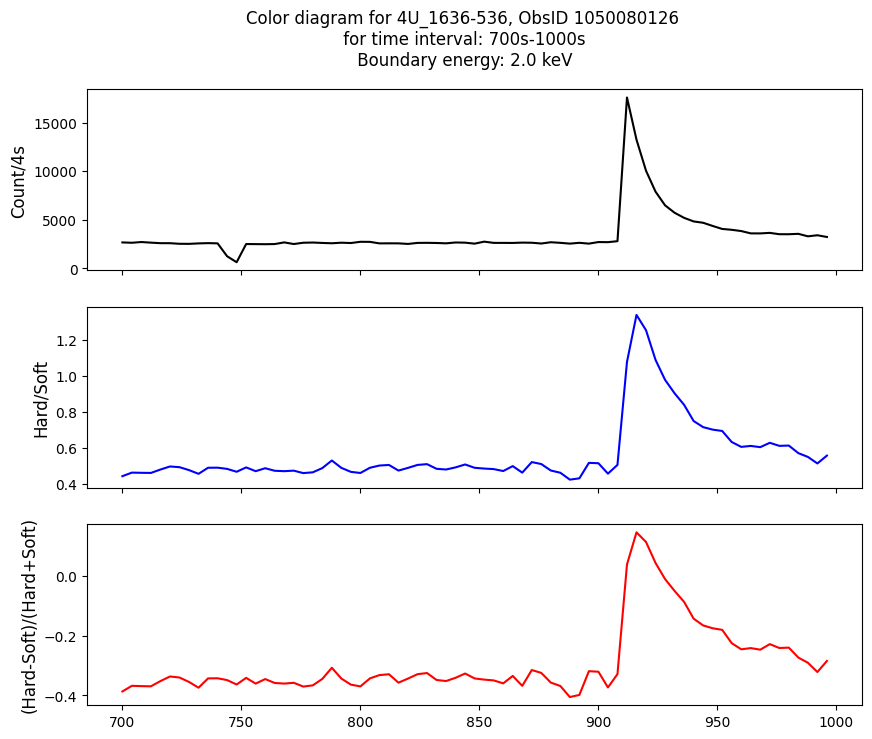

In [20]:
##CCD&HID
def soft_counts(E_bound, pi_data):
    """
    从数据中获取一个 PI 值数组，其中每个条目表示 1 个计数。
    因此，构建一个长度相等的全 1 数组，然后将 E >= E_bound 的位置设置为 0。
    这样会得到一个数组，其中 0 表示更硬的 X 射线，1 表示更软的 X 射线，因此在进行分箱时，只会得到软计数。

    E_bound - 考虑的边界能量（单位为 keV）
    pi_data - PI 值数组
    """
    if E_bound < 0 or E_bound > 20:
        raise ValueError("您的 E_bound 小于 0 keV 或大于 20 keV - 请检查输入！")
    # if len(times) != len(pi_data):
    #     raise ValueError("时间数组和 PI 数组长度不同。请调查！")

    counts = np.ones(len(pi_data))
    PI_bound = E_bound * 1000 / 10  # 获取 PI 的截止值；截止值以 keV 为单位！
    # 我们假设不会有计数为零的箱
    np.place(counts, pi_data >= PI_bound, 0)  # 获取软光子的计数

    return counts

def hard_counts(E_bound,pi_data):
    """
    与上面的类似
    """
    if E_bound < 0 or E_bound > 20:
        raise ValueError("您的 E_bound 小于 0 keV 或大于 20 keV - 请检查输入！")
    counts = np.ones(len(pi_data))
    PI_bound = E_bound*1000/10 
    np.place(counts,pi_data<PI_bound,0)  # 获取硬光子的计数
    return counts

def get_color_t(eventfile,par_list,E_bound,tbin_size,t1,t2):
    """
    Calculating the color - hard/soft and (hard-soft)/(hard+soft)

    eventfile - path to the event file. Will extract ObsID from this for the NICER files.
    par_list - A list of parameters we'd like to extract from the FITS file
    (e.g., from eventcl, PI_FAST, TIME, PI,)
    E_bound - boundary energy considered (in keV)
    tbin_size - the size of the time bins (in seconds!)
    >> e.g., tbin_size = 2 means bin by 2s
    >> e.g., tbin_size = 0.05 means bin by 0.05s!
    t1 - lower time boundary
    t2 - upper time boundary
    """
    if type(eventfile) != str:
        raise TypeError("eventfile should be a string!")
    if 'PI' and 'TIME' not in par_list:
        raise ValueError("You should have BOTH 'PI' and 'TIME' in the parameter list!")
    if type(par_list) != list and type(par_list) != np.ndarray:
        raise TypeError("par_list should either be a list or an array!")

    data_dict = fits2dict(eventfile,par_list,1)
    pi_data = data_dict['PI']
    soft = soft_counts(E_bound,pi_data)
    hard = hard_counts(E_bound,pi_data)

    times = data_dict['TIME']
    shifted_t = times-times[0]
    truncated_t = shifted_t[(shifted_t>=t1)&(shifted_t<=t2)]
    truncated_soft = soft[(shifted_t>=t1)&(shifted_t<=t2)]
    truncated_hard = hard[(shifted_t>=t1)&(shifted_t<=t2)]

    if len(truncated_soft) != len(truncated_hard):
        raise ValueError("Length of truncated soft and hard arrays are not the same for some reason!")

    startt = int(t1)
    endt = int(t2)
    num_bins = int((endt - startt) * 1 / tbin_size) + 1  # 将结果转换为整数
    t_bins = np.linspace(startt, endt, num_bins)
    sum_soft, bin_edges_soft, binnumber_soft = stats.binned_statistic(shifted_t,soft,statistic='sum',bins=t_bins)
    sum_hard, bin_edges_hard, binnumber_hard = stats.binned_statistic(shifted_t,hard,statistic='sum',bins=t_bins)
    np.place(sum_soft,sum_soft==0,1) #so that you get 0/1 instead

    color = sum_hard/sum_soft
    color_diff = (sum_hard-sum_soft)/(sum_soft+sum_hard)

    return t_bins,color,color_diff

def plotting_t(eventfile,par_list,E_bound,tbin_size,t1,t2,mode):
    """
    绘制硬度比/色图。

    t_bins, color, color_diff = get_color_t(eventfile, par_list, E_bound, tbin_size)

    eventfile - 事件文件的路径。将从中提取 ObsID，用于 NICER 文件。
    par_list - 我们希望从 FITS 文件中提取的参数列表
    （例如，来自 eventcl 的 PI_FAST, TIME, PI 等）
    E_bound - 考虑的边界能量（单位为 keV）
    tbin_size - 时间箱的大小（单位为秒！）
    >> 例如，tbin_size = 2 表示按 2 秒分箱
    >> 例如，tbin_size = 0.05 表示按 0.05 秒分箱
    t1 - 下时间边界
    t2 - 上时间边界
    mode - 是否展示或保存图表。
    """
    if type(eventfile) != str:
        raise TypeError("eventfile 应该是一个字符串！")
    if 'PI' not in par_list or 'TIME' not in par_list:
        raise ValueError("参数列表中应该同时包含 'PI' 和 'TIME'！")
    if type(par_list) != list and type(par_list) != np.ndarray:
        raise TypeError("par_list 应该是一个列表或数组！")
    if mode != 'show' and mode != 'save':
        raise ValueError("Mode 应该是 'show' 或 'save'！")

    parent_folder = str(pathlib.Path(eventfile).parent)

    #### FOR LIGHT CURVE
    truncated_t,truncated_E =filter_time(path_evt,par_list,[t1,t2],[])
    truncated_t, truncated_counts = binning_tE(truncated_t, truncated_E, tbin_size)

    event_header = fits.open(eventfile)[1].header
    obj_name = event_header['OBJECT']
    obsid = event_header['OBS_ID']

    tbins,color,color_diff = get_color_t(eventfile,par_list,E_bound,tbin_size,t1,t2)

    fig, (ax1,ax2,ax3) = plt.subplots(3,1,sharex=True,figsize=(10,8))
    fig.suptitle('Color diagram for ' + obj_name + ', ObsID ' + str(obsid) + '\n for time interval: ' + str(t1) + 's-'+str(t2)+'s'+ '\n Boundary energy: ' + str(E_bound) + ' keV', fontsize=12)

    ax1.plot(truncated_t[:-1],truncated_counts,'k')
    ax1.set_ylabel('Count/'+str(tbin_size)+'s',fontsize=12)

    ax2.plot(tbins[:-1],color,'b')
    ax2.set_ylabel('Hard/Soft',fontsize=12)

    ax3.plot(tbins[:-1],color_diff,'r')
    ax3.set_ylabel('(Hard-Soft)/(Hard+Soft)',fontsize=12)

    plt.subplots_adjust(hspace=0.2)

    if mode == 'show':
        plt.show()

    elif mode == 'save':
        filename = 'co_' + obsid + '_bin' + str(tbin_size) + 's_' + str(t1) + 's-' + str(t2) + 's.pdf'
        plt.savefig(parent_folder+'/'+filename,dpi=900)
        plt.close()

cl_path = '/home/pl/work/python-workspance/nicer-pl/1050080126/ni1050080126_0mpu7_cl.evt'
plotting_t(cl_path,['TIME','PI','PI_FAST'],2.0,4,700,1000,'show')


加载FITS文件并提取参数...
提取时间和PI数据...
总时间点数量: 1207192
总能量点数量: 1207192
应用时间过滤: t1=800, t2=1000
应用能量过滤: E1=0.3 kev, E2=6 kev
结合时间和能量过滤条件...
过滤后的时间点数量: 190843
过滤后的能量点数量: 190843
时间分箱已完成，分箱步长为 1 s
能量分箱已完成，分箱步长为 0.05 keV。


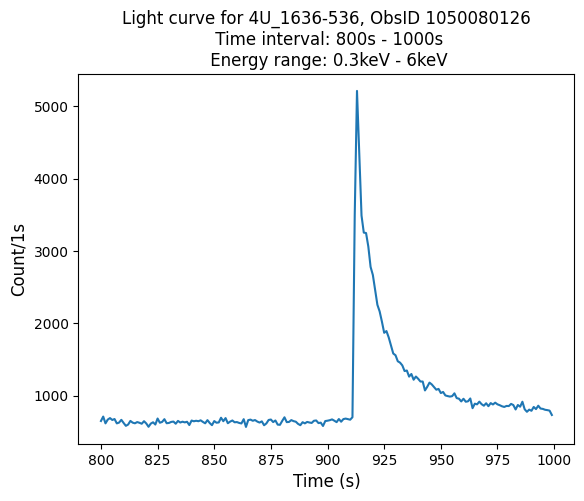

In [21]:
def partial_tE(eventfile,par_list,tbin_size,t_list,e_list,mode):
    """
    Plot the time series for a desired time interval and desired energy range.

    """

    truncated_t,truncated_E =filter_time(eventfile,par_list,t_list,e_list)
    truncated_t, truncated_t_counts, truncated_E, truncated_E_counts = binning_tE(truncated_t, truncated_E, tbin_size,Ebin_size=0.05 ,e_list=e_list)
    #put in Ebin_size of 0.05 keV; I'm plotting light curves in this script, so truncated_E and truncated_E_counts are not needed

    t1,t2 = t_list[0],t_list[1]
    E1,E2 = e_list[0],e_list[1]
    parent_folder = str(pathlib.Path(eventfile).parent)
    event_header = fits.open(eventfile)[1].header
    obj_name = event_header['OBJECT']
    obsid = event_header['OBS_ID']

    plt.figure()
    plt.plot(truncated_t[:-1], truncated_t_counts)
    plt.title('Light curve for ' + obj_name + ', ObsID ' + str(obsid)+ '\n Time interval: ' + str(t1) + 's - ' + str(t2) + 's'+ '\n Energy range: ' + str(E1) + 'keV - ' + str(E2) + 'keV',fontsize=12)
    plt.xlabel('Time (s)', fontsize=12)
    plt.ylabel('Count/' + str(tbin_size) + 's',fontsize=12)

    if mode == 'show':
        plt.show()
    elif mode == 'save':
        filename = 'lc_' + obsid + '_bin' + str(tbin_size) + 's_' + str(t1) + 's-' + str(t2) + 's_' + str(E1) + 'keV-' + str(E2) + 'keV.pdf'
        plt.savefig(parent_folder+'/'+filename,dpi=900)
        plt.close()

clean_evt = '/home/pl/work/python-workspance/nicer-pl/1050080126_pipe/cleanfilt.evt'
partial_tE(clean_evt,['TIME','PI','PI_FAST'],1,[800,1000],[0.3,6],'show')